In [1]:
import os
import operator
import uuid
from typing import Annotated, Dict, List, Optional, Tuple, TypedDict

from IPython.display import Image, display
from langchain_community.utils.math import cosine_similarity
from langchain_tavily import TavilySearch
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_ollama import OllamaEmbeddings
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore
from langgraph.graph import END, START, StateGraph
from pydantic import BaseModel, Field
from semantic_chunkers import StatisticalChunker
from semantic_router.encoders import OpenAIEncoder

In [2]:
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')
#TavilySearch
os.environ["TAVILY_API_KEY"] = os.getenv('TAVILY_API_KEY')

tavily_search = TavilySearch(max_results=3)
llm = ChatOpenAI(model="gpt-4.1-2025-04-14", temperature=0)
embeddings = OllamaEmbeddings(model="bge-m3:latest")

In [3]:
class Goals(BaseModel):
    """Structure for defining learning goals"""
    goals: str = Field(None, description="Learning goals")

class LearningCheckpoint(BaseModel):
    """Structure for a single checkpoint"""
    description: str = Field(..., description="Main checkpoint description")
    criteria: List[str] = Field(..., description="List of success criteria")
    verification: str = Field(..., description="How to verify this checkpoint")

class Checkpoints(BaseModel):
    """Main checkpoints container with index tracking"""
    checkpoints: List[LearningCheckpoint] = Field(
        ..., 
        description="List of checkpoints covering foundation, application, and mastery levels"
    )

class SearchQuery(BaseModel):
    """Structure for search query collection"""
    search_queries: list = Field(None, description="Search queries for retrieval.")

class LearningVerification(BaseModel):
    """Structure for verification results"""
    understanding_level: float = Field(..., ge=0, le=1)
    feedback: str
    suggestions: List[str]
    context_alignment: bool

class FeynmanTeaching(BaseModel):
    """Structure for Feynman teaching method"""
    simplified_explanation: str
    key_concepts: List[str]
    analogies: List[str]

class QuestionOutput(BaseModel):
    """Structure for question generation output"""
    question: str

class InContext(BaseModel):
    """Structure for context verification"""
    is_in_context: str = Field(..., description="Yes or No")

In [4]:
class LearningtState(TypedDict):
    topic: str
    goals: List[Goals]
    context: str
    context_chunks: Annotated[list, operator.add]
    context_key: str
    search_queries: SearchQuery
    checkpoints: Checkpoints
    verifications: LearningVerification
    teachings: FeynmanTeaching
    current_checkpoint: int
    current_question: QuestionOutput
    current_answer: str

In [5]:
def extract_content_from_chunks(chunks):
    """Extract and combine content from chunks with splits attribute.
    
    Args:
        chunks: List of chunk objects that may contain splits attribute
        
    Returns:
        str: Combined content from all chunks joined with newlines
    """
    content = []
    
    for chunk in chunks:
        if hasattr(chunk, 'splits') and chunk.splits:
            chunk_content = ' '.join(chunk.splits)
            content.append(chunk_content)
    
    return '\n'.join(content)

def format_checkpoints_as_message(checkpoints: Checkpoints) -> str:
    """Convert Checkpoints object to a formatted string for the message.
    
    Args:
        checkpoints (Checkpoints): Checkpoints object containing learning checkpoints
        
    Returns:
        str: Formatted string containing numbered checkpoints with descriptions and criteria
    """
    message = "Here are the learning checkpoints:\n\n"
    for i, checkpoint in enumerate(checkpoints.checkpoints, 1):
        message += f"Checkpoint {i}:\n"
        message += f"Description: {checkpoint.description}\n"
        message += "Success Criteria:\n"
        for criterion in checkpoint.criteria:
            message += f"- {criterion}\n"
    return message

def generate_checkpoint_message(checks: List[LearningCheckpoint]) -> HumanMessage:
    """Generate a formatted message for learning checkpoints that need context.
    
    Args:
        checks (List[LearningCheckpoint]): List of learning checkpoint objects
        
    Returns:
        HumanMessage: Formatted message containing checkpoint descriptions, criteria and 
                     verification methods, ready for context search
    """
    formatted_checks = []
    
    for check in checks:
        checkpoint_text = f"""
        Description: {check.description}
        Success Criteria:
        {chr(10).join(f'- {criterion}' for criterion in check.criteria)}
        Verification Method: {check.verification}
        """
        formatted_checks.append(checkpoint_text)
    
    all_checks = "\n---\n".join(formatted_checks)
    
    checkpoints_message = HumanMessage(content=f"""The following learning checkpoints need additional context:
        {all_checks}
        
        Please generate search queries to find relevant information.""")
    
    return checkpoints_message

In [6]:
learning_checkpoints_generator = SystemMessage(content="""You will be given a learning topic title and learning objectives.
Your goal is to generate clear learning checkpoints that will help verify understanding and progress through the topic.
The output should be in the following dictionary structure:
checkpoint 
-> description (level checkpoint description)
-> criteria
-> verification (How to verify this checkpoint (Feynman Methods))
Requirements for each checkpoint:
- Description should be clear and concise
- Criteria should be specific and measurable (3-5 items)
- Verification method should be practical and appropriate for the level
- Verification will be checked by language model, so it must by in natural language
- All elements should align with the learning objectives
- Use action verbs and clear language
Ensure all checkpoints progress logically from foundation to mastery.
IMPORTANT - ANSWER ONLY 3 CHECKPOINTS""")

checkpoint_based_query_generator = SystemMessage(content="""You will be given learning checkpoints for a topic.
Your goal is to generate search queries that will retrieve content matching each checkpoint's requirements from retrieval systems or web search.
Follow these steps:
1. Analyze each learning checkpoint carefully
2. For each checkpoint, generate ONE targeted search query that will retrieve:
   - Content for checkpoint verification""")

validate_context = SystemMessage(content="""You will be given a learning criteria and context.
Check if the the criteria could be answered using the context.
Always answer YES or NO""")

question_generator = SystemMessage(content="""You will be given a checkpoint description, success criteria, and verification method.
Your goal is to generate an appropriate question that aligns with the checkpoint's verification requirements.
The question should:
1. Follow the specified verification method
2. Cover all success criteria
3. Encourage demonstration of understanding
4. Be clear and specific
Output should be a single, well-formulated question that effectively tests the checkpoint's learning objectives.""")

answer_verifier = SystemMessage(content="""You will be given a student's answer, question, checkpoint details, and relevant context.
Your goal is to analyze the answer against the checkpoint criteria and provided context.
Analyze considering:
1. Alignment with verification method specified
2. Coverage of all success criteria
3. Use of relevant concepts from context
4. Depth and accuracy of understanding
Output should include:
- understanding_level: float between 0 and 1
- feedback: detailed explanation of the assessment
- suggestions: list of specific improvements
- context_alignment: boolean indicating if the answer aligns with provided context""")

feynman_teacher = SystemMessage(content="""You will be given verification results, checkpoint criteria, and learning context.
Your goal is to create a Feynman-style teaching explanation for concepts that need reinforcement.
The explanation should include:
1. Simplified explanation without technical jargon
2. Concrete, relatable analogies
3. Key concepts to remember
Output should follow the Feynman technique:
- simplified_explanation: clear, jargon-free explanation
- key_concepts: list of essential points
- analogies: list of relevant, concrete comparisons
Focus on making complex ideas accessible and memorable.""")

In [7]:
class ContextStore:
    """Store for managing context chunks and their embeddings in memory.
    
    A class that provides storage and retrieval of context data using an in-memory store.
    Each context entry consists of context chunks and their corresponding embeddings.
    """
    
    def __init__(self):
        """Initialize ContextStore with an empty in-memory store."""
        self.store = InMemoryStore()
        
    def save_context(self, context_chunks: list, embeddings: list, key: str = None):
        """Save context chunks and their embeddings to the store.
        
        Args:
            context_chunks (list): List of context chunk objects
            embeddings (list): List of corresponding embeddings for the chunks
            key (str, optional): Custom key for storing the context. Defaults to None,
                               in which case a UUID is generated.
            
        Returns:
            str: The key used to store the context
        """
        namespace = ("context",)
        
        if key is None:
            key = str(uuid.uuid4())
            
        value = {
            "chunks": context_chunks,
            "embeddings": embeddings
        }
        
        self.store.put(namespace, key, value)
        return key
        
    def get_context(self, context_key: str):
        """Retrieve context data from the store using a key.
        
        Args:
            context_key (str): The key used to store the context
            
        Returns:
            dict: The stored context value containing chunks and embeddings
        """
        namespace = ("context",)
        memory = self.store.get(namespace, context_key)
        return memory.value

In [8]:
def generate_query(state: LearningtState):
    """Generates search queries based on learning checkpoints from current state."""
    structured_llm = llm.with_structured_output(SearchQuery) 
    checkpoints_message = HumanMessage(content=format_checkpoints_as_message(state['checkpoints']))  
    messages = [checkpoint_based_query_generator, checkpoints_message]
    search_queries = structured_llm.invoke(messages)
    return {"search_queries": search_queries}

def search_web(state: LearningtState):
    """Retrieves and processes web search results based on search queries."""
    search_queries = state["search_queries"].search_queries
    
    all_search_docs = []
    for query in search_queries:
        search_docs = tavily_search.invoke(query)
        all_search_docs.extend(search_docs)
    
    formatted_search_docs = [
        f'Context: {doc["content"]}\n Source: {doc["url"]}\n'
        for doc in all_search_docs
    ]

    chunk_embeddings = embeddings.embed_documents(formatted_search_docs)
    context_key = context_store.save_context(
        formatted_search_docs,
        chunk_embeddings,
        key=state.get('context_key')
    )
    
    return {"context_chunks": formatted_search_docs}

def generate_checkpoints(state: LearningtState):
    """Creates learning checkpoints based on given topic and goals."""
    structured_llm = llm.with_structured_output(Checkpoints)
    messages = [
        learning_checkpoints_generator,
        SystemMessage(content=f"Topic: {state['topic']}"),
        SystemMessage(content=f"Goals: {', '.join(str(goal) for goal in state['goals'])}")
    ]
    checkpoints = structured_llm.invoke(messages)
    return {"checkpoints": checkpoints}

def chunk_context(state: LearningtState):
    """Splits context into manageable chunks and generates their embeddings."""
    encoder = OpenAIEncoder(name="text-embedding-3-large")
    chunker = StatisticalChunker(
        encoder=encoder,
        min_split_tokens=128,
        max_split_tokens=512
    )
    
    chunks = chunker([state['context']])
    content = []
    for chunk in chunks:
        content.append(extract_content_from_chunks(chunk))

    chunk_embeddings = embeddings.embed_documents(content)
    context_key = context_store.save_context(
        content,
        chunk_embeddings,
        key=state.get('context_key')
    )
    return {"context_chunks": content, "context_key": context_key}

def context_validation(state: LearningtState):
    """Validates context coverage against checkpoint criteria using stored embeddings."""
    context = context_store.get_context(state['context_key'])
    chunks = context['chunks']
    chunk_embeddings = context['embeddings']
    
    checks = []
    structured_llm = llm.with_structured_output(InContext)
    
    for checkpoint in state['checkpoints'].checkpoints:
        query = embeddings.embed_query(checkpoint.verification)
        
        similarities = cosine_similarity([query], chunk_embeddings)[0]
        top_3_indices = sorted(range(len(similarities)), 
                             key=lambda i: similarities[i], 
                             reverse=True)[:3]
        relevant_chunks = [chunks[i] for i in top_3_indices]
        
        messages = [
            validate_context,
            HumanMessage(content=f"""
            Criteria:
            {chr(10).join(f"- {c}" for c in checkpoint.criteria)}
            
            Context:
            {chr(10).join(relevant_chunks)}
            """)
        ]
        
        response = structured_llm.invoke(messages)
        if response.is_in_context.lower() == "no":
            checks.append(checkpoint)
    
    if checks:
        structured_llm = llm.with_structured_output(SearchQuery)
        checkpoints_message = generate_checkpoint_message(checks)
        
        messages = [checkpoint_based_query_generator, checkpoints_message]
        search_queries = structured_llm.invoke(messages)
        return {"search_queries": search_queries}
    
    return {"search_queries": None}

def generate_question(state: LearningtState):
    """Generates assessment questions based on current checkpoint verification requirements."""
    structured_llm = llm.with_structured_output(QuestionOutput)
    current_checkpoint = state['current_checkpoint']
    checkpoint_info = state['checkpoints'].checkpoints[current_checkpoint]
    
    messages = [
        question_generator,
        HumanMessage(content=f"""
        Checkpoint Description: {checkpoint_info.description}
        Success Criteria:
        {chr(10).join(f"- {c}" for c in checkpoint_info.criteria)}
        Verification Method: {checkpoint_info.verification}
        
        Generate an appropriate verification question.""")
    ]
    
    question_output = structured_llm.invoke(messages)
    return {"current_question": question_output.question}

def verify_answer(state: LearningtState):
    """Evaluates user answers against checkpoint criteria using relevant context chunks."""
    structured_llm = llm.with_structured_output(LearningVerification)
    current_checkpoint = state['current_checkpoint']
    checkpoint_info = state['checkpoints'].checkpoints[current_checkpoint]
    
    context = context_store.get_context(state['context_key'])
    chunks = context['chunks']
    chunk_embeddings = context['embeddings']
    
    query = embeddings.embed_query(checkpoint_info.verification)
    
    similarities = cosine_similarity([query], chunk_embeddings)[0]
    top_3_indices = sorted(range(len(similarities)), 
                         key=lambda i: similarities[i], 
                         reverse=True)[:3]
    relevant_chunks = [chunks[i] for i in top_3_indices]
    
    messages = [
        answer_verifier,
        HumanMessage(content=f"""
        Question: {state['current_question']}
        Answer: {state['current_answer']}
        
        Checkpoint Description: {checkpoint_info.description}
        Success Criteria:
        {chr(10).join(f"- {c}" for c in checkpoint_info.criteria)}
        Verification Method: {checkpoint_info.verification}
        
        Context:
        {chr(10).join(relevant_chunks)}
        
        Assess the answer.""")
    ]
    
    verification = structured_llm.invoke(messages)
    return {"verifications": verification}
    
def teach_concept(state: LearningtState):
    """Creates simplified Feynman-style explanations for concepts that need reinforcement."""
    structured_llm = llm.with_structured_output(FeynmanTeaching)
    current_checkpoint = state['current_checkpoint']
    checkpoint_info = state['checkpoints'].checkpoints[current_checkpoint]
    
    messages = [
        feynman_teacher,
        HumanMessage(content=f"""
        Criteria: {checkpoint_info.criteria}
        Verification: {state['verifications']}
        
        Context:
        {state['context_chunks']}
        
        Create a Feynman teaching explanation.""")
    ]
    
    teaching = structured_llm.invoke(messages)
    return {"teachings": teaching}

In [9]:
def user_answer(state: LearningtState):
    """Placeholder for handling user's answer input."""
    pass

def next_checkpoint(state: LearningtState):
    """Advances to the next checkpoint in the learning sequence."""
    current_checkpoint = state['current_checkpoint'] + 1
    return {'current_checkpoint': current_checkpoint}

In [10]:
def route_context(state: LearningtState):
    """Determines whether to process existing context or generate new search queries."""
    if state.get("context"):
        return 'chunk_context'
    return 'generate_query'

def route_verification(state: LearningtState):
    """Determines next step based on verification results and checkpoint progress."""
    current_checkpoint = state['current_checkpoint']
    
    if state['verifications'].understanding_level < 0.7:
        return 'teach_concept'
        
    if current_checkpoint + 1 < len(state['checkpoints'].checkpoints):
        return 'next_checkpoint'
    
    return END

def route_teaching(state: LearningtState):
    """Routes to next checkpoint or ends session after teaching intervention."""
    current_checkpoint = state['current_checkpoint']
    if current_checkpoint + 1 < len(state['checkpoints'].checkpoints):
        return 'next_checkpoint'
    return END

def route_search(state: LearningtState):
    """Directs flow between question generation and web search based on query status."""
    if state['search_queries'] is None:
        return "generate_question"
    return "search_web"

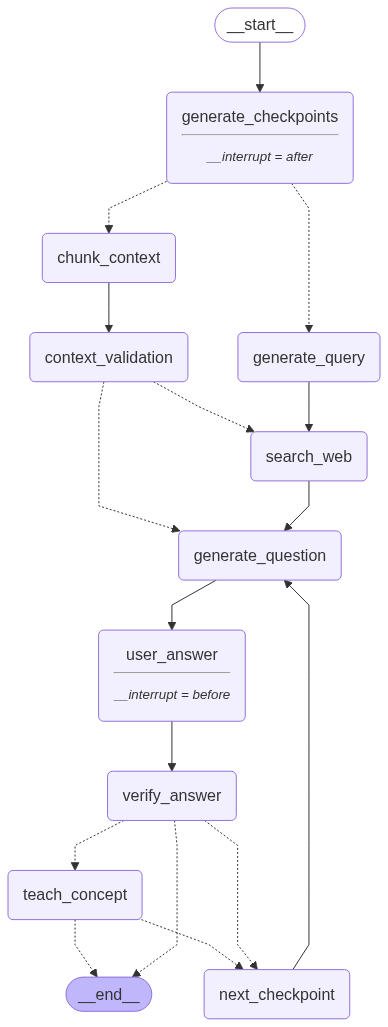

In [11]:
searcher = StateGraph(LearningtState)
memory = MemorySaver()
context_store = ContextStore()

searcher.add_node("generate_query", generate_query)
searcher.add_node("search_web", search_web)
searcher.add_node("chunk_context", chunk_context)
searcher.add_node("context_validation", context_validation)
searcher.add_node("generate_checkpoints", generate_checkpoints)
searcher.add_node("generate_question", generate_question)
searcher.add_node("next_checkpoint", next_checkpoint)
searcher.add_node("user_answer", user_answer)
searcher.add_node("verify_answer", verify_answer)
searcher.add_node("teach_concept", teach_concept)

# Flow
searcher.add_edge(START, "generate_checkpoints")
searcher.add_conditional_edges('generate_checkpoints', route_context,['chunk_context', 'generate_query'])
searcher.add_edge("generate_query", "search_web")
searcher.add_edge("search_web", "generate_question")
searcher.add_edge("chunk_context", 'context_validation')
searcher.add_conditional_edges('context_validation', route_search,['search_web', 'generate_question'])

searcher.add_edge("generate_question", "user_answer")
searcher.add_edge("user_answer", "verify_answer")
searcher.add_conditional_edges(
    "verify_answer",
    route_verification,
    {
        "next_checkpoint": "next_checkpoint",
        "teach_concept": "teach_concept",
        END: END
    }
)

searcher.add_conditional_edges(
    "teach_concept",
    route_teaching,
    {
        "next_checkpoint": "next_checkpoint",
        END: END
    }
)
searcher.add_edge("next_checkpoint", "generate_question")



graph = searcher.compile(interrupt_after=["generate_checkpoints"], interrupt_before=["user_answer"], checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [12]:
def print_checkpoints(event):
    """Pretty print checkpoints information with improved visual formatting"""
    checkpoints = event.get('checkpoints', '')
    if checkpoints:
        print("\n" + "=" * 80)
        print("🎯 LEARNING CHECKPOINTS OVERVIEW".center(80))
        print("=" * 80 + "\n")
        
        for i, checkpoint in enumerate(checkpoints.checkpoints, 1):
            # Checkpoint header with number
            print(f"📍 CHECKPOINT #{i}".center(80))
            print("─" * 80 + "\n")
            
            # Description section with text wrapping
            print("📝 Description:")
            print("─" * 40)
            words = checkpoint.description.split()
            current_line = []
            current_length = 0
            
            for word in words:
                if current_length + len(word) + 1 <= 70:
                    current_line.append(word)
                    current_length += len(word) + 1
                else:
                    print(f"  {' '.join(current_line)}")
                    current_line = [word]
                    current_length = len(word)
            
            if current_line:
                print(f"  {' '.join(current_line)}")
            print()
            
            # Success Criteria section
            print("✅ Success Criteria:")
            print("─" * 40)
            for j, criterion in enumerate(checkpoint.criteria, 1):
                # Wrap each criterion text
                words = criterion.split()
                current_line = []
                current_length = 0
                first_line = True
                
                for word in words:
                    if current_length + len(word) + 1 <= 66:  # Shorter width to account for numbering
                        current_line.append(word)
                        current_length += len(word) + 1
                    else:
                        if first_line:
                            print(f"  {j}. {' '.join(current_line)}")
                            first_line = False
                        else:
                            print(f"     {' '.join(current_line)}")
                        current_line = [word]
                        current_length = len(word)
                
                if current_line:
                    if first_line:
                        print(f"  {j}. {' '.join(current_line)}")
                    else:
                        print(f"     {' '.join(current_line)}")
            print()
            
            # Verification Method section
            print("🔍 Verification Method:")
            print("─" * 40)
            words = checkpoint.verification.split()
            current_line = []
            current_length = 0
            
            for word in words:
                if current_length + len(word) + 1 <= 70:
                    current_line.append(word)
                    current_length += len(word) + 1
                else:
                    print(f"  {' '.join(current_line)}")
                    current_line = [word]
                    current_length = len(word)
            
            if current_line:
                print(f"  {' '.join(current_line)}")
            print()
            
            # Separator between checkpoints
            if i < len(checkpoints.checkpoints):
                print("~" * 80 + "\n")
        
        print("=" * 80 + "\n")

def print_verification_results(event):
    """Pretty print verification results with improved formatting"""
    verifications = event.get('verifications', '')
    if verifications:
        print("\n" + "=" * 50)
        print("📊 VERIFICATION RESULTS".center(50))
        print("=" * 50 + "\n")

        # Understanding Level with visual bar
        understanding = verifications.understanding_level
        bar_length = 20
        filled_length = int(understanding * bar_length)
        bar = "█" * filled_length + "░" * (bar_length - filled_length)
        
        print(f"📈 Understanding Level: [{bar}] {understanding * 100:.1f}%\n")
        
        # Feedback section
        print("💡 Feedback:")
        print(f"{verifications.feedback}\n")
        
        # Suggestions section
        print("🎯 Suggestions:")
        for i, suggestion in enumerate(verifications.suggestions, 1):
            print(f"  {i}. {suggestion}")
        print()
        
        # Context Alignment
        print("🔍 Context Alignment:")
        print(f"{verifications.context_alignment}\n")
        
        print("-" * 50 + "\n")
def print_teaching_results(event):
    """Pretty print Feynman teaching results with improved formatting"""
    teachings = event.get('teachings', '')
    if teachings:
        print("\n" + "=" * 70)
        print("🎓 FEYNMAN TEACHING EXPLANATION".center(70))
        print("=" * 70 + "\n")

        # Simplified Explanation section
        print("📚 SIMPLIFIED EXPLANATION:")
        print("─" * 30)
        # Split explanation into paragraphs for better readability
        paragraphs = teachings.simplified_explanation.split('\n')
        for paragraph in paragraphs:
            # Wrap text at 60 characters for better readability
            words = paragraph.split()
            lines = []
            current_line = []
            current_length = 0
            
            for word in words:
                if current_length + len(word) + 1 <= 60:
                    current_line.append(word)
                    current_length += len(word) + 1
                else:
                    lines.append(' '.join(current_line))
                    current_line = [word]
                    current_length = len(word)
            
            if current_line:
                lines.append(' '.join(current_line))
            
            for line in lines:
                print(f"{line}")
            print()
        
        # Key Concepts section
        print("💡 KEY CONCEPTS:")
        print("─" * 30)
        for i, concept in enumerate(teachings.key_concepts, 1):
            print(f"  {i}. {concept}")
        print()
        
        # Analogies section
        print("🔄 ANALOGIES & EXAMPLES:")
        print("─" * 30)
        for i, analogy in enumerate(teachings.analogies, 1):
            print(f"  {i}. {analogy}")
        print()
        
        print("=" * 70 + "\n")

Example School Note

In [13]:
note = """ChatGPT의 말:

빈혈: 종합 개요

정의
빈혈은 적혈구(RBC) 또는 혈액 내 헤모글로빈 수치가 감소하는 의학적 상태를 말한다. 이로 인해 체내 조직으로 산소를 운반하는 능력이 떨어져 전반적인 신체 기능과 건강에 영향을 준다.

혈액 성분과 그 역할
적혈구(erythrocyte)는 혈액의 주요 성분으로, 온몸에 산소를 운반하는 역할을 한다. 이 세포들은 철분을 함유한 단백질인 헤모글로빈을 포함하며, 이는 혈액의 특유의 붉은 색을 띠게 하고 산소 운반에 핵심적인 역할을 한다. 적혈구의 평균 수명은 약 120일이며, 이후 골수에서 새 세포가 만들어져 교체된다.

빈혈의 유형

철 결핍성 빈혈: 전 세계적으로 가장 흔한 빈혈로, 철분 섭취 부족이나 흡수 장애로 발생한다. 특히 임산부, 성장기 아동, 가임기 여성, 영양 상태가 좋지 않은 사람에게 흔하다.

비타민 결핍성 빈혈: 비타민 B12 또는 엽산(비타민 B9)이 부족할 때 발생한다. 이는 식이 부족이나 소화기관에서의 흡수 문제로 인해 나타날 수 있다.

재생불량성 빈혈: 드물지만 심각한 유형으로, 골수가 충분한 혈액 세포를 만들지 못하는 상태다. 유전적 요인에 의해 발생할 수 있으며, 환경적 요인이나 다른 의학적 상태로 인해 후천적으로 나타나기도 한다.

용혈성 빈혈: 적혈구가 정상보다 빠르게 파괴되어 체내에서 이를 충분히 보충하지 못할 때 발생한다. 이는 유전적 요인이나 외부 요인에 의해 발생할 수 있다.

임상 증상
빈혈은 지속적인 피로와 무력감으로 나타나며, 창백하거나 누런 피부색, 호흡곤란, 어지럼증이 흔하다. 그 외 불규칙한 심장 박동, 잦은 두통, 손발이 차가움, 가슴 통증 등이 동반될 수 있다.

진단 접근법
진단은 의사의 철저한 신체 검진으로 시작된다. 이후 전혈구검사(CBC), 철분 수치 측정, 비타민 B12 측정, 엽산 수치 측정 등 혈액 검사가 핵심적이다. 이러한 검사는 빈혈의 유형을 파악하고 적절한 치료 방향을 설정하는 데 도움을 준다.

치료 전략

식이 요법: 철분이 풍부한 음식(붉은 고기, 짙은 녹색 잎채소, 콩류, 철분 강화 시리얼 등)을 섭취하는 것이 기본이다.

영양제 보충: 원인에 따라 철분제, 비타민 B12, 엽산 보충제가 필요할 수 있다.

의학적 치료: 중증 빈혈은 수혈이 필요할 수 있으며, 재생불량성 빈혈의 경우 골수 이식이 고려될 수 있다.

예방 방법
예방은 철분, 비타민 B12, 엽산, 그리고 철분 흡수를 돕는 비타민 C가 풍부한 균형 잡힌 식단을 유지하는 것이다. 또한 정기적인 건강검진을 통해 조기 발견 및 치료가 가능하다.
특히 임산부, 가임기 여성, 성장기 아동, 채식주의자, 영양 요구량이 높은 운동선수는 예방 관리가 중요하다.

잠재적 합병증
치료하지 않은 빈혈은 심각한 합병증으로 이어질 수 있다. 여기에는 일상생활을 방해하는 심한 피로, 임신 중 합병증, 심혈관 질환, 우울증, 학업 및 업무 수행에 영향을 주는 인지 장애 등이 포함된다.

임상적 의의
빈혈은 종종 다른 기저 질환을 시사하는 지표가 된다. 따라서 조기 발견과 적절한 치료가 최적의 결과를 위해 필수적이다. 빈혈의 유형에 따라 치료법이 달라지며, 치료 효과를 확인하기 위해 정기적인 모니터링이 필요할 수 있다."""

Initial state

In [14]:
initial_input = {
    "topic": "Anemia",
    'goals': ['Im medical student, i want to master the diagnosis of Anemia'],
    'context': note,
    'current_checkpoint': 0}

Generate learning checkpoints

In [15]:
thread = {"configurable": {"thread_id": "20"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    print_checkpoints(event)


                        🎯 LEARNING CHECKPOINTS OVERVIEW                         

                                📍 CHECKPOINT #1                                 
────────────────────────────────────────────────────────────────────────────────

📝 Description:
────────────────────────────────────────
  Understand the basic definitions, types, and causes of anemia.

✅ Success Criteria:
────────────────────────────────────────
  1. Define anemia and explain its clinical significance.
  2. List and differentiate the main types of anemia (microcytic,
     normocytic, macrocytic).
  3. Identify common causes for each type of anemia.

🔍 Verification Method:
────────────────────────────────────────
  Explain anemia and its types to a peer as if they have no medical
  background. List at least two causes for each type and describe why
  they lead to anemia.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

                                📍 CHECKPOINT #2        

Widget for checkpoin management

In [16]:
from typing import List
import ipywidgets as widgets
from IPython.display import display
from pydantic import BaseModel

def create_checkpoint_editor(checkpoints_model: Checkpoints):
    """
    Creates an interactive checkpoint editor using a Pydantic model.
    
    Args:
        checkpoints_model: Pydantic model of Checkpoints class
    """
    # Convert to list of dictionaries for easier editing
    checkpoints = [cp.model_dump() for cp in checkpoints_model.checkpoints]
    checkpoints_widgets = []
    accepted_checkpoints = []
    
    def create_criterion_widget(checkpoint_index: int, criterion_value: str = "", criterion_index: int = None):
        """Creates a widget for a single criterion with a delete button"""
        criterion_container = widgets.HBox([
            widgets.Text(
                value=criterion_value,
                description=f'{criterion_index + 1}.' if criterion_index is not None else 'New',
                layout=widgets.Layout(width='85%')
            ),
            widgets.Button(
                description='Delete',
                button_style='danger',
                layout=widgets.Layout(width='15%')
            )
        ])
        
        def on_criterion_change(change):
            nonlocal criterion_index
            if criterion_index is not None:
                checkpoints[checkpoint_index]['criteria'][criterion_index] = change['new']
        
        def remove_criterion(b):
            if criterion_index is not None:
                checkpoints[checkpoint_index]['criteria'].pop(criterion_index)
                update_checkpoint_widget(checkpoint_index)
        
        criterion_container.children[0].observe(on_criterion_change, names='value')
        criterion_container.children[1].on_click(remove_criterion)
        
        return criterion_container
    
    def create_checkpoint_widget(checkpoint: dict, index: int):
        """Creates a widget for a single checkpoint"""
        
        def on_accept_change(change):
            if change['new']:
                accepted_checkpoints.append(index)
            else:
                if index in accepted_checkpoints:
                    accepted_checkpoints.remove(index)
        
        def on_description_change(change):
            checkpoints[index]['description'] = change['new']
        
        def on_verification_change(change):
            checkpoints[index]['verification'] = change['new']
        
        def add_criterion(b):
            checkpoints[index]['criteria'].append("")
            update_checkpoint_widget(index)
        
        def remove_checkpoint(b):
            checkpoints.pop(index)
            update_all_checkpoints()
        
        # Header with checkbox and delete button
        header = widgets.HBox([
            widgets.HTML(f'<h3 style="margin: 0;">Checkpoint {index + 1}</h3>'),
            widgets.Checkbox(
                value=False,
                description='Accept',
                indent=False,
                layout=widgets.Layout(margin='5px 0 0 20px')
            ),
            widgets.Button(
                description='Delete checkpoint',
                button_style='danger',
                layout=widgets.Layout(margin='0 0 0 20px')
            )
        ])
        
        # Description
        description = widgets.Textarea(
            value=checkpoint['description'],
            description='Description:',
            layout=widgets.Layout(width='95%', height='60px')
        )
        
        # Criteria
        criteria_label = widgets.HTML('<b>Criteria:</b>')
        criteria_container = widgets.VBox([
            create_criterion_widget(index, criterion, i)
            for i, criterion in enumerate(checkpoint['criteria'])
        ])
        
        # Add criterion button
        add_criterion_btn = widgets.Button(
            description='Add criterion',
            button_style='success',
            layout=widgets.Layout(margin='10px 0')
        )
        
        # Verification
        verification = widgets.Textarea(
            value=checkpoint['verification'],
            description='Verification:',
            layout=widgets.Layout(width='95%', height='60px', margin='10px 0')
        )
        
        separator = widgets.HTML('<hr style="margin: 20px 0;">')
        
        # Combine all elements
        checkpoint_widget = widgets.VBox([
            header,
            description,
            criteria_label,
            criteria_container,
            add_criterion_btn,
            verification,
            separator
        ])
        
        # Add observers and handlers
        header.children[1].observe(on_accept_change, names='value')
        header.children[2].on_click(remove_checkpoint)
        description.observe(on_description_change, names='value')
        verification.observe(on_verification_change, names='value')
        add_criterion_btn.on_click(add_criterion)
        
        return checkpoint_widget
    
    def update_checkpoint_widget(index: int):
        """Updates a single checkpoint widget"""
        if 0 <= index < len(checkpoints):
            checkpoints_widgets[index] = create_checkpoint_widget(checkpoints[index], index)
            update_main_container()
    
    def update_all_checkpoints():
        """Updates all checkpoint widgets"""
        nonlocal checkpoints_widgets
        checkpoints_widgets = [
            create_checkpoint_widget(checkpoint, i)
            for i, checkpoint in enumerate(checkpoints)
        ]
        update_main_container()
    
    def add_new_checkpoint(b):
        """Adds a new checkpoint"""
        checkpoints.append({
            'description': '',
            'criteria': [],
            'verification': ''
        })
        update_all_checkpoints()
    
    def get_pydantic_model() -> Checkpoints:
        """Converts the current editor state back to a Pydantic model"""
        return Checkpoints(checkpoints=[
            LearningCheckpoint(**checkpoint)
            for checkpoint in checkpoints
        ])
    
    # Create initial checkpoint widgets
    checkpoints_widgets = [
        create_checkpoint_widget(checkpoint, i)
        for i, checkpoint in enumerate(checkpoints)
    ]
    
    # Add new checkpoint button
    add_checkpoint_btn = widgets.Button(
        description='Add checkpoint',
        button_style='success',
        layout=widgets.Layout(margin='20px 0')
    )
    add_checkpoint_btn.on_click(add_new_checkpoint)
    
    # Main container
    main_container = widgets.VBox(
        checkpoints_widgets + [add_checkpoint_btn],
        layout=widgets.Layout(
            padding='20px',
            border='1px solid #ddd',
            border_radius='5px'
        )
    )
    
    def update_main_container():
        """Updates the main container"""
        main_container.children = tuple(checkpoints_widgets + [add_checkpoint_btn])
    
    # Add method to container to retrieve data later
    main_container.get_model = get_pydantic_model
    
    return main_container